In [17]:
from pytorch_tabnet.tab_model import TabNetClassifier

import os
import torch
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Creditos a Diego Fernandez por el manejo de los datos.

In [19]:
folder = "Data"
años = ["19-20", "20-21", "21-22", "22-23", "23-24"]
torneos = []

for año in años:
    match_file = f"stats_{año}.csv"
    path_matches = os.path.join(folder, match_file)
    matches = pd.read_csv(path_matches)
    torneos.append(matches)

Se borran los partidos de cada torneo en los que no hay registro de los equipos que jugaron.

In [20]:
for torneo in torneos:
    torneo.dropna(subset=['team_home', 'team_away'], inplace=True)

Ahora, se eliminan las columnas que tengan datos faltantes.

In [21]:
columns_with_null = []

for torneo in torneos:
    null_columns = torneo.columns[torneo.isna().any()].tolist()
    columns_with_null.append(null_columns)

columns_with_null

unique_columns = list(set(itertools.chain.from_iterable(columns_with_null)))
unique_columns

#Borrar para cada torneo las columnas en unique_columns
for torneo in torneos:
    torneo.drop(columns=unique_columns, inplace=True)

In [22]:
torneos2 = []

for torneo in torneos:
    torneo.sort_values(by='number_of_match', inplace=True)
    torneo.rename(columns={'home_score': 'score_home', 'away_score': 'score_away'}, inplace=True)

    ##OJOO arreglar tema de equipos
    team_counts = pd.concat([torneo['team_home'], torneo['team_away']]).value_counts()
    teams_to_remove = team_counts[team_counts < 5].index

    torneo = torneo[~(torneo['team_home'].isin(teams_to_remove) | torneo['team_away'].isin(teams_to_remove))]
    torneos2.append(torneo)

In [23]:
torneos = torneos2
torneos[0].head()

#Cantidad de datos en cada torneo
for torneo in torneos:
    print(torneo.shape)

(378, 51)
(380, 51)
(374, 51)
(380, 51)
(132, 51)


Se generan las tablas para cada temporada.

In [24]:
def remove_suffix(item):
    return item.replace("_home", "").replace("_away", "")

column = [remove_suffix(item) for item in matches.columns]
columnas = []
[columnas.append(x) for x in column if x not in columnas]
columnas.remove("number_of_match")
columnas.remove("team")
columnas[0] = "score_prom"
print(columnas)
print(len(columnas))

['score_prom', 'posession', 'total_shots', 'shots_on_target', 'shots_off_target', 'blocked_shots', 'corner_kicks', 'fouls', 'red_cards', 'free_kicks', 'goal_kicks', 'shots_inside_box', 'shots_outside_box', 'passes', 'accurate_passes', 'long_balls', 'crosses', 'dribbles', 'duels_won', 'aerials_won', 'tackles', 'interceptions', 'last_season_position', 'ELO']
24


In [25]:
columnas.append("wins")
columnas.append("ties")
columnas.append("losses")
columnas.append("total_goals")
columnas.append("total_goals_conceded")
columnas.append("points")
columnas.append("streak")
columnas.append("wins_in_last_5_matches")
columnas.append("ties_in_last_5_matches")
columnas.append("losses_in_last_5_matches")

In [26]:
tablas = []

for torneo, i in zip(torneos, range(len(torneos))):

    torneo.loc[:, "team_home"] = torneo["team_home"].apply(lambda x: x.replace("AFC ", ""))
    torneo.loc[:, "team_away"] = torneo["team_away"].apply(lambda x: x.replace("AFC ", ""))

    torneo.loc[:, "team_home"] = torneo["team_home"].apply(lambda x: x.replace("West Ham United", "West Ham"))
    torneo.loc[:, "team_away"] = torneo["team_away"].apply(lambda x: x.replace("West Ham United", "West Ham"))

    torneo.loc[:, "team_home"] = torneo["team_home"].apply(lambda x: x.replace(" Hotspur", ""))
    torneo.loc[:, "team_away"] = torneo["team_away"].apply(lambda x: x.replace(" Hotspur", ""))

    torneo.loc[:, "team_home"] = torneo["team_home"].apply(lambda x: x.replace("Brighton & Hove Albion", "Brighton"))
    torneo.loc[:, "team_away"] = torneo["team_away"].apply(lambda x: x.replace("Brighton & Hove Albion", "Brighton"))

    equipos = torneo["team_home"].unique()
    equipos2 = torneo["team_away"].unique()
    print(len(equipos), len(equipos2))
    print(equipos)
    stats = columnas

    tabla = {}

    for equipo in equipos:

        tabla[equipo] = dict.fromkeys(stats, 0)
        tabla[equipo]["last_5_matches"] = list()

    tablas.append(tabla)

20 20
['Liverpool' 'West Ham' 'Bournemouth' 'Burnley' 'Crystal Palace' 'Watford'
 'Tottenham' 'Newcastle United' 'Manchester United' 'Arsenal'
 'Aston Villa' 'Brighton' 'Everton' 'Norwich City' 'Southampton'
 'Manchester City' 'Sheffield United' 'Chelsea' 'Wolverhampton'
 'Leicester City']
20 20
['Fulham' 'Crystal Palace' 'Liverpool' 'West Ham' 'West Bromwich Albion'
 'Tottenham' 'Sheffield United' 'Brighton' 'Burnley' 'Manchester City'
 'Everton' 'Leeds United' 'Manchester United' 'Arsenal' 'Southampton'
 'Newcastle United' 'Chelsea' 'Leicester City' 'Aston Villa'
 'Wolverhampton']
20 20
['Brentford' 'Manchester United' 'Burnley' 'Chelsea' 'Everton'
 'Leicester City' 'Watford' 'Norwich City' 'Newcastle United' 'Tottenham'
 'Liverpool' 'Aston Villa' 'Crystal Palace' 'Leeds United'
 'Manchester City' 'Brighton' 'Southampton' 'Wolverhampton' 'Arsenal'
 'West Ham']
20 20
['Crystal Palace' 'Fulham' 'Bournemouth' 'Leeds United' 'Newcastle United'
 'Tottenham' 'Everton' 'Leicester City' 'Man

In [27]:
new_stats = ["wins",
"ties",
"losses",
"total_goals",
"total_goals_conceded",
"points",
"streak",
"wins_in_last_5_matches",
"ties_in_last_5_matches",
"losses_in_last_5_matches"]
procesated_matches_columns = list(torneos[0].columns)
procesated_matches_columns.insert(5, "score_prom_away")
procesated_matches_columns.insert(5, "score_prom_home")

for stat in new_stats:
    procesated_matches_columns.append(f"{stat}_home")
    procesated_matches_columns.append(f"{stat}_away")

procesated_matches = pd.DataFrame(columns = procesated_matches_columns)

procesated_matches.head()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away


In [28]:
for torneo, i in zip(torneos, range(len(torneos))):
    tabla = tablas[i]
    for index in torneo.index:
    
        """Escribir info en el nuevo df de partidos con la información hasta el partido la cual esta almacenada en 'tabla'"""
        match = torneo.loc[index]
        team_home = match["team_home"]
        team_away = match["team_away"]

        stats_home = tabla[team_home]
        stats_away = tabla[team_away]

        fila = []
        fila.append(match["number_of_match"])
        fila.append(team_home)
        fila.append(team_away)
        fila.append(match["score_home"])
        fila.append(match["score_away"])

        for stat in stats:
            
            fila.append(tabla[team_home][stat])
            fila.append(tabla[team_away][stat])
        
        procesated_matches.loc[len(procesated_matches)] = fila
        
        """ Actualizar la tabla con lo que realmente ocurrió en ese partido"""

        matches_played_home = tabla[team_home]["wins"] + tabla[team_home]["ties"] + tabla[team_home]["losses"]+1
        matches_played_away = tabla[team_away]["wins"] + tabla[team_away]["ties"] + tabla[team_away]["losses"]+1
        
        ## stats promediadas:
        for stat in stats[:stats.index("wins")]:
            if stat == "score_prom":
                tabla[team_home][stat] = (tabla[team_home][stat]*(matches_played_home-1) + match["score_home"])/matches_played_home
                tabla[team_away][stat] = (tabla[team_away][stat]*(matches_played_away-1) + match["score_away"])/matches_played_away
            else:
                tabla[team_home][stat] = (tabla[team_home][stat]*(matches_played_home-1) + match[f"{stat}_home"])/matches_played_home
                tabla[team_away][stat] = (tabla[team_away][stat]*(matches_played_away-1) + match[f"{stat}_away"])/matches_played_away
            
        ## stats acumuladas
        
        empate = False
        if match["score_home"] > match["score_away"]:

            #victorias / derrotas
            tabla[team_home]["wins"] += 1
            tabla[team_away]["losses"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["score_home"]
            tabla[team_away]["total_goals"] += match["score_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["score_away"]
            tabla[team_away]["total_goals_conceded"] += match["score_home"]

            #puntos
            tabla[team_home]["points"] += 3

            # racha
            tabla[team_home]["streak"] += 1
            tabla[team_away]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_home]["last_5_matches"].append("W")
            tabla[team_away]["last_5_matches"].append("L")


        elif match["score_home"] < match["score_away"]:

            #victorias / derrotas
            tabla[team_away]["wins"] += 1
            tabla[team_home]["losses"] += 1

            #goles a favor
            tabla[team_away]["total_goals"] += match["score_away"]
            tabla[team_home]["total_goals"] += match["score_home"]

            #goles en contra
            tabla[team_away]["total_goals_conceded"] += match["score_home"]
            tabla[team_home]["total_goals_conceded"] += match["score_away"]

            #puntos
            tabla[team_away]["points"] += 3

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("W")
            tabla[team_home]["last_5_matches"].append("L")

        else:
            #empate
            tabla[team_home]["ties"] += 1
            tabla[team_away]["ties"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["score_home"]
            tabla[team_away]["total_goals"] += match["score_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["score_away"]
            tabla[team_away]["total_goals_conceded"] += match["score_home"]

            #puntos
            tabla[team_home]["points"] += 1
            tabla[team_away]["points"] += 1

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] += 1

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("T")
            tabla[team_home]["last_5_matches"].append("T")

        tabla[team_home]["wins_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("W")
        tabla[team_home]["ties_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("T")
        tabla[team_home]["losses_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("L")

        tabla[team_away]["wins_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("W")
        tabla[team_away]["ties_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("T")
        tabla[team_away]["losses_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("L")

In [39]:
procesated_matches.tail()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away
1639,129,Everton,Manchester United,0.0,3.0,1.181818,1.083333,41.636364,54.250000,14.272727,...,13,21,2,2,3,4,0,0,2,1
1640,130,Fulham,Wolverhampton,3.0,2.0,0.833333,1.333333,48.750000,47.833333,11.083333,...,12,15,0,1,1,2,1,2,3,1
1641,131,Arsenal,Wolverhampton,2.0,1.0,2.076923,1.384615,61.230769,47.230769,14.538462,...,30,15,2,0,3,2,1,1,1,2
1642,132,Brentford,Luton Town,3.0,1.0,1.461538,0.923077,46.923077,35.769231,14.153846,...,16,9,0,1,3,1,0,2,2,2
1643,147,Aston Villa,Manchester City,1.0,0.0,2.384615,2.538462,52.538462,62.384615,14.923077,...,28,29,2,5,4,3,0,2,1,0


In [40]:
#Exportar a csv
#procesated_matches.to_csv("procesated_matches.csv", index=False)

In [29]:
#Usamos el GPU si esta disponible, mps porque es apple silicon.
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"using {device}")

using mps


In [30]:
matches = procesated_matches

#Aqui agrega la columna de resultados

results = []

for index in matches.index:

    match = matches.loc[index]
    if match["score_home"] > match["score_away"]:
        results.append(1)
    elif match["score_home"] < match["score_away"]:
        results.append(2)
    else:
        results.append(0)

matches["result"] = results

In [31]:
matches.head()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away,result
0,0,Liverpool,Norwich City,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,West Ham,Manchester City,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
2,2,Bournemouth,Sheffield United,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Burnley,Southampton,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,4,Crystal Palace,Everton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Cantidad de partidos por resultado (local, empate, visita)

for i in range(0,3):
    cantidad = matches[matches["result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos")
num = 722/(371+722+551)
print("azar:", num)

Resultado 0, hay: 371 partidos
Resultado 1, hay: 722 partidos
Resultado 2, hay: 551 partidos
azar: 0.4391727493917275


In [33]:
#Ahora,vamos a separar el último torneo

cant_partidos_ultima_temp = len(torneos[-1])

matches_train = matches.iloc[:-cant_partidos_ultima_temp]
matches_test = matches.iloc[-cant_partidos_ultima_temp:]

result_train = matches_train["result"]
result_test = matches_test["result"]
matches_train = matches_train.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away", "number_of_match"])
matches_test = matches_test.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away", "number_of_match"])

matches_train.tail(), matches_test.tail()

(      score_prom_home  score_prom_away  posession_home  posession_away  \
 1507         0.891892         1.000000       42.702703       39.540541   
 1508         1.270270         1.783784       46.810811       50.000000   
 1509         1.324324         1.108108       47.648649       41.378378   
 1510         1.513514         1.459459       53.810811       48.675676   
 1511         0.864865         1.918919       44.837838       60.810811   
 
       total_shots_home  total_shots_away  shots_on_target_home  \
 1507         11.243243          9.486486              3.945946   
 1508         11.972973         13.702703              3.864865   
 1509         10.945946         12.378378              4.000000   
 1510         15.459459         11.324324              5.594595   
 1511         10.864865         15.540541              3.567568   
 
       shots_on_target_away  shots_off_target_home  shots_off_target_away  ...  \
 1507              3.540541               4.054054            

In [34]:
result = matches["result"]
matches = matches.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away"])
matches.head()

columnas_categoricas = matches.select_dtypes(include=['object']).columns.tolist()

print("Columnas categóricas:")
print(columnas_categoricas)

Columnas categóricas:
[]


In [47]:
# Convertir columnas categoricas a numericas

#col = LabelEncoder().fit(matches["columna_tabla"])
#data["columna_tabla"] = col.transform(matches["columna_tabla"])

In [35]:
'''
X = matches.to_numpy()
scaler = StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result
'''

X = matches_train.to_numpy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = result_train

X_test = scaler.transform(matches_test.to_numpy())
y_test = result_test

In [49]:
#X_train, X_test, y_train, y_test = train_test_split(X_escalados, y, test_size=0.3, random_state = 1, stratify=y)

In [36]:
#kfold = KFold(n_splits=5)

#y_true_all = []
#y_pred_all = []

#for train_index, test_index in kfold.split(X_escalados):
#X_train, X_test = X_escalados[train_index], X_escalados[test_index]
#y_train, y_test = y[train_index], y[test_index]
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, # how to use learning rate scheduler
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=100, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)
# Almacenar las predicciones
#y_true_all.extend(y_test)
#y_pred_all.extend(pred)

/Users/gustavofernandez/Desktop/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2801  | train_accuracy: 0.36508 | valid_accuracy: 0.39394 |  0:00:00s
epoch 1  | loss: 1.17636 | train_accuracy: 0.375   | valid_accuracy: 0.42424 |  0:00:01s
epoch 2  | loss: 1.14552 | train_accuracy: 0.41667 | valid_accuracy: 0.43939 |  0:00:01s
epoch 3  | loss: 1.13855 | train_accuracy: 0.42857 | valid_accuracy: 0.44697 |  0:00:02s
epoch 4  | loss: 1.11609 | train_accuracy: 0.43254 | valid_accuracy: 0.45455 |  0:00:02s
epoch 5  | loss: 1.10944 | train_accuracy: 0.43519 | valid_accuracy: 0.44697 |  0:00:03s
epoch 6  | loss: 1.11027 | train_accuracy: 0.44114 | valid_accuracy: 0.43939 |  0:00:04s
epoch 7  | loss: 1.09642 | train_accuracy: 0.44378 | valid_accuracy: 0.43182 |  0:00:04s
epoch 8  | loss: 1.07901 | train_accuracy: 0.45767 | valid_accuracy: 0.46212 |  0:00:05s
epoch 9  | loss: 1.07502 | train_accuracy: 0.4709  | valid_accuracy: 0.47727 |  0:00:05s
epoch 10 | loss: 1.0715  | train_accuracy: 0.46296 | valid_accuracy: 0.47727 |  0:00:06s
epoch 11 | loss: 1.05

/Users/gustavofernandez/Desktop/iPre-resultados-deportivos/env/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [37]:
print("classification report")
print(classification_report(y_test, pred))

classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.58      0.80      0.68        61
           2       0.57      0.59      0.58        46

    accuracy                           0.58       132
   macro avg       0.39      0.46      0.42       132
weighted avg       0.47      0.58      0.51       132



Normalized confusion matrix


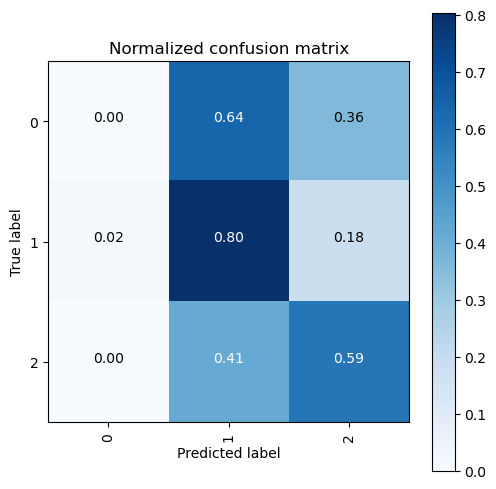

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, pred)
classes = np.unique(y_train)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))

plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()